In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os 
from astropy.io import ascii
from tqdm import tqdm
from astropy.convolution import convolve, Gaussian1DKernel
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import pickle
from Doublet_Quantifier.curvefit import *
from Doublet_Quantifier.models import *


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
sys.path.append('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/')
from functions.data_tools import *
from functions.plotting_tools import *


In [4]:
# opening pseudo-voigt parameter DataFrame
mypath = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/'
with open(mypath + "diamondback-data/pickle_files/parameters/t1500_parameter_df.pkl", "rb") as f:
    parameter_df = pickle.load(f)

### preforming cross validation 

In [5]:
cv_data = parameter_df[parameter_df.clouds!=10] # taking out the nc as fsed is not reliable

#creating shuffled index
rng = np.random.default_rng()
rand_index = rng.permutation(len(cv_data))

cv_A = ((cv_data.A1 + cv_data.A2)/2 ).values[rand_index]
cv_fsed = cv_data.clouds.values[rand_index]

cv_FWHM = ((cv_data.FWHM1 + cv_data.FWHM2)/2 ).values[rand_index]
cv_logg = cv_data.logg.values[rand_index]

# Create a linear regression model
model = LinearRegression()

# Perform cross-validation
# Here, cv=5 means 5-fold cross-validation
# You can adjust cv to change the number of folds
# FWHM and logg
scores = cross_val_score(model, cv_FWHM.reshape(-1, 1), cv_logg.reshape(-1, 1), cv=5, scoring='neg_mean_squared_error')
Pearson_corr_coef_1, p_value = stats.pearsonr(cv_logg, cv_FWHM)

# Print the cross-validation scores
print("Cross-Validation root mean squared error for logg:", np.sqrt(-scores).mean())
print("Pearson product-moment correlation coefficient:", Pearson_corr_coef_1)
print("P-value:", p_value)
print()

# A and fsed
scores = cross_val_score(model, cv_A.reshape(-1, 1), cv_fsed.reshape(-1, 1), cv=5, scoring='neg_mean_squared_error')
Pearson_corr_coef_2, p_value = stats.pearsonr(cv_fsed, cv_A)
# Print the cross-validation scores
print("Cross-Validation root mean squared error for fsed:", np.sqrt(-scores).mean())
print("Pearson product-moment correlation coefficient:", Pearson_corr_coef_2)
print("P-value:", p_value)



Cross-Validation root mean squared error for logg: 0.16902521520480968
Pearson product-moment correlation coefficient: 0.9714962631535549
P-value: 7.069868614596894e-16

Cross-Validation root mean squared error for fsed: 1.0944825325202387
Pearson product-moment correlation coefficient: -0.8893428076131401
P-value: 2.7934545219150827e-09


In [6]:
fsed_values = np.array([i for i in range(0,10)])
logg_values = np.array([i for i in range(3,7)])

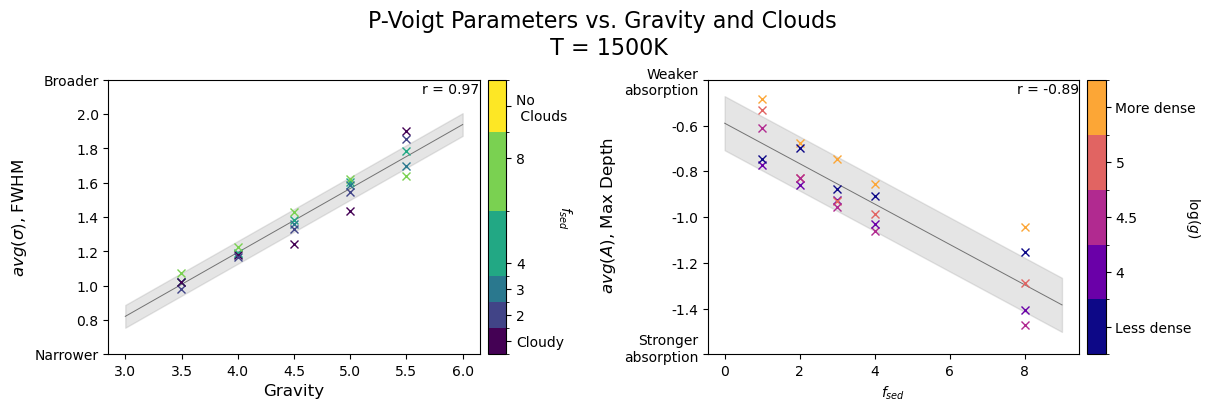

In [8]:
fig = plt.figure(figsize=(12, 4), constrained_layout=True)

gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.05, 1, 0.05])

ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])
cax1, cax2 = fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 3]) 

# plotting data points 
for i in range(len(cv_FWHM)):
        ax1.errorbar(cv_logg[i], cv_FWHM[i],
                    color=fsed_colors(norm_f(cv_fsed[i])), fmt='x')
        ax2.errorbar(cv_fsed[i], cv_A[i], 
                    color=logg_colors(norm_g(cv_logg[i])), fmt='x')

# plotting lines 
m, b = np.polyfit(cv_logg, cv_FWHM, 1)
y_est = logg_values*m + b
ax1.plot(logg_values, y_est, color='k',
        linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
y_err = np.sqrt((-cross_val_score(model, cv_logg.reshape(-1, 1), cv_FWHM.reshape(-1, 1), cv=5, scoring='neg_mean_squared_error'))).mean()
ax1.fill_between(logg_values, y_est - y_err, y_est + y_err, alpha=0.2, color = 'grey')


m, b = np.polyfit(cv_fsed, cv_A, 1)
y_est = fsed_values*m + b
ax2.plot(fsed_values, y_est, color='k',
        linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
y_err =  np.sqrt(-(cross_val_score(model, cv_fsed.reshape(-1, 1), cv_A.reshape(-1, 1), cv=5, scoring='neg_mean_squared_error'))).mean()
ax2.fill_between(fsed_values, y_est - y_err, y_est + y_err, alpha=0.2, color = 'grey')

# Colorbar

axcb = logg_colorbar(fig, cax = cax2,  orientation='vertical')
axcb.set_label(r'$\log(g)$' , fontsize=10, rotation = -90) 



axcb = fsed_colorbar(fig, cax = cax1,  orientation='vertical')
axcb.set_label(r'$f_{sed}$', fontsize=10, rotation = -90) 



# r value 
ax1.annotate(f"r = {Pearson_corr_coef_1:.2}", xy=(1, 0.99),
            ha='right', va='top',
            fontsize=10,
            xycoords='axes fraction', color='k')
ax2.annotate(f"r = {Pearson_corr_coef_2:.2}", xy=(1, 0.99),
            ha='right', va='top',
            fontsize=10,
            xycoords='axes fraction', color='k')

# set axis
yticks = ax2.get_yticks()
ylabel = list(yticks.copy()/1e11)
ylabel[0] = "Stronger\nabsorption\n"
ylabel[-1] = "Weaker\nabsorption"
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabel)

yticks = ax1.get_yticks()
ylabel = list(np.around(yticks.copy()/1e-3, 1))
ylabel[-1] = "Broader"
ylabel[0] = "Narrower"
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabel)
ax1.set_yticks(yticks)



# set labels
ax2.set_ylabel("\n $avg(A)$, Max Depth", fontsize=12)
ax1.set_ylabel("$avg(\sigma)$, FWHM", fontsize=12)
ax1.set_xlabel("Gravity", fontsize=12)
ax2.set_xlabel(r"$f_{sed}$")

fig.suptitle('P-Voigt Parameters vs. Gravity and Clouds \n T = 1500K', fontsize=16)

plt.savefig("/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/CV_plot.png")